In [17]:
try:
    import sim
except:
    print('Sim error')

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import numpy

In [18]:
def att_force(q, goal, katt= 0.1):
  Fatt = katt *(np.array(goal) - np.array(q))
  return Fatt

In [19]:
def rep_force(q, obs, R=1, krep= 0.1):
  v = np.array(q) - np.arrray(obs[0:2])
  d = np.linalg.norm(v) - obs[2]
  #d = d.reshape((len(v),1))
  rep = (1/d**2) * ((1/d) - (1/R)) * (v/d)

  invalid = np.squeeze(d > R)
  rep[invalid, :] = 0

  return np.array(krep)*np.array(rep)


In [20]:
def force(q,goal,laser_data,HWL,posLaser,max_sensor_range = 5):
    Frep = [0,0]

    for i in range(len(laser_data)):
      ang, dist = laser_data[i]
      if (max_sensor_range - dist) > 0.1:
        x = dist * np.cos(ang)
        y = dist * np.sin(ang)

        Aux = np.array(HWL@[x,y,posLaser[2],1])
        obs = [Aux[0],Aux[1],0.5]
        Aux3 = np.array(rep_force(q, obs))
      else:
        Aux3 = 0
      Frep = np.array(Frep) + np.array(Aux3)
    Fatt= att_force(q,goal)
    Ft = Fatt + Frep
    return Ft

In [21]:
def readSensorData(clientId=-1,
                   range_data_signal_id = "hokuyo_range_data",
                   angle_data_signal_id = "hokuyo_angle_data"):
    # the first call should be non-blocking to avoid getting out-of-sync angle data
  returnCodeRanges, string_range_data = sim.simxGetStringSignal(clientId, range_data_signal_id, sim.simx_opmode_streaming)

    # the second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
  returnCodeAngles, string_angle_data = sim.simxGetStringSignal(clientId, angle_data_signal_id, sim.simx_opmode_blocking)

  if returnCodeRanges == 0 and returnCodeAngles == 0:
    raw_range_data = sim.simxUnpackFloats(string_range_data)
    raw_angle_data = sim.simxUnpackFloats(string_angle_data)

    return raw_range_data,raw_angle_data

  return None

In [22]:
def Transformacao(robotHandle, LaserHandle, GoalHandle):

  returnCode, posRobo = sim.simxGetObjectPosition(clientID,robotHandle,-1, sim.simx_opmode_oneshot_wait)
  returnCode, OrientacaoRobo = sim.simxGetObjectPosition(clientID,robotHandle,-1, sim.simx_opmode_oneshot_wait)
  returnCode, posLaser = sim.simxGetObjectPosition(clientID,LaserHandle,-1, sim.simx_opmode_oneshot_wait)
  returnCode, OrientacaoLaser = sim.simxGetObjectPosition(clientID,LaserHandle,-1, sim.simx_opmode_oneshot_wait)
  returnCode, posgoal = sim.simxGetObjectPosition(clientID,GoalHandle,-1, sim.simx_opmode_oneshot_wait)

  RWL = [[np.cos(OrientacaoLaser[2]),     -np.sin(OrientacaoLaser[2]),    0],
        [np.sin(OrientacaoLaser[2]),      np.cos(OrientacaoLaser[2]),     0],
         [ 0,0,1]]

  TWL = [posLaser[0],posLaser[1],posLaser[2]]

  HWL = np.column_stack((RWL, TWL))

  aux = np.array([0,0,0,1])
  HWL = np.row_stack((HWL, aux))

  return HWL, posRobo, posgoal, OrientacaoRobo[2], posLaser

In [23]:
def draw_laser_data2(laser_data,posRobo,posLaser,HWL, max_sensor_range=5):
  for i in range(len(laser_data)):
      ang, dist = laser_data[i]
      if (max_sensor_range - dist) > 0.1:
        x = dist * np.cos(ang)
        y = dist * np.sin(ang)
        c = 'r'
        if ang < 0:
          c = 'b'
        Pw = np.array(HWL@[x,y,posLaser[2],1])
        ax2.plot(Pw[0],Pw[1],'o', color=c)
  ax2.plot(posRobo[0],posRobo[1],'k>', markersize=10)

Program Started
Connected to remote API Server
Robo ->  38


KeyboardInterrupt: 

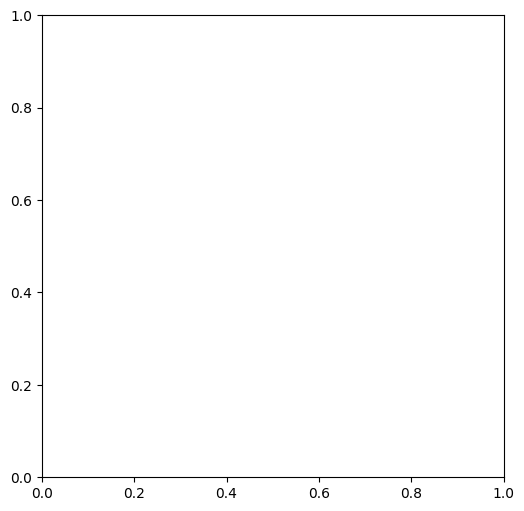

In [24]:
print('Program Started')
sim.simxFinish(-1)
# defaults are host='localhost', port=23000)
clientID=sim.simxStart('127.0.0.1', 19999,True,True,5000,5)

if clientID!=-1:
  print('Connected to remote API Server')

  robotname = 'Pioneer_p3dx'
  returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
  print("Robo -> ", robotHandle)

  returnCode, l_whell = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
  returnCode, r_whell = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)

  laser_range_data = "hokuyo_range_data"
  laser_angle_data = "hokuyo_angle_data"

  Lasername = 'fastHokuyo'
  returnCode, laserHandle = sim.simxGetObjectHandle(clientID, Lasername, sim.simx_opmode_oneshot_wait)

  Goalname = 'Floor0'
  returnCode, laserHandle = sim.simxGetObjectHandle(clientID, Goalname, sim.simx_opmode_oneshot_wait)

  fig = plt.figure(figsize=(6,6), dpi=100)
  ax2 = fig.add_subplot(111, aspect='equal')
  max_sensor_range=5

  returnCode = 1
  while returnCode != 0:
    returnCode, range_data = sim.simxGetObjectHandle(clientID, laser_range_data, sim.simx_opmode_streaming + 10)

  raw_range_data, raw_angle_data = readSensorData(clientID,laser_range_data, laser_angle_data)
  laser_data = np.array([raw_angle_data,raw_range_data]).T

  Dados = Transformacao(robotHandle,LaserHandle, GoalHandle)

  draw_laser_data2(laser_data, Dados[1],Dados[4], Dados[0])

  HWL = Dados[0]
  posRobo = Dados[1]
  posgoal = Dados[2]
  OrientacaozRobo = Dados[3]
  posLaser = Dados[4]

  ax2.grid()
  ax2.set_xlim([-max_sensor_range, max_sensor_range])
  ax2.set_ylim([-max_sensor_range, max_sensor_range])

  L = 0.331
  r = 0.09751

  following = False

  t= 0
  startTime = time.time()
  lastTime = startTime

  maxv = 1
  maxw = np.deg2rad(45)

  Ft_x = 0
  Ft_y = 0

  while t < 120:
    Dados = Transformacao(robotHandle,LaserHandle, GoalHandle)
    raw_range_data, raw_angle_data = readSensorData(clientID,laser_range_data, laser_angle_data)
    laser_data = np.array([raw_angle_data,raw_range_data]).T

    draw_laser_data2(laser_data, Dados[1],Dados[4], Dados[0])

    HWL = Dados[0]
    posRobo = Dados[1]
    posgoal = Dados[2]
    OrientacaozRobo = Dados[3]
    posLaser = Dados[4]

    ax2.plot(posgoal[0],posgoal[1], 'o', color='g')

    ax2.grid()
    ax2.set_xlim([-max_sensor_range, max_sensor_range])
    ax2.set_ylim([-max_sensor_range, max_sensor_range])

    init = [posRobo[0], posRobo[1]]
    goal = [posgoal[0], posgoal[1]]

    now = time.time()
    dt = now - lastTime

    v = .4
    w = 0

    kv = 1
    kw = 2

    Ft = force(init,goal,laser_data,HWL,posLaser)

    Ft_x = Ft[0]
    Ft_y = Ft[1]

    if((Ft_x + Ft_y) == 0):
      Ft_x = +0.1
      Ft_y = +0.1

    v = (kv * ((Ft_x*(np.cos(laser_ori[2])) + Ft_y*(np.sin(laser_ori[2])))))
    w = (kw*((np.arctan2(Ft_y, Ft_x))-laser_ori[2]))
    w = (w + np.pi) % (2 * np.pi) - np.pi 

    # limit v,w to +/- max
    v = max(min(v, maxv), -maxv)
    w = max(min(w, maxw), -maxw)

    # Calcular as velocidades das rodas
    vr = (2*v + L*w) / (2*r)
    vl = (2*v - L*w) / (2*r)

            # Setando as velocidades
    sim.setJointTargetVelocity(motorLeft, vl)
    sim.setJointTargetVelocity(motorRight, vr)

    t = t + dt
    lastTime = now

else:
    print("Failed to connect to remote API server")
    print("Exiting...")

print("Program ended")


print("Program ended")
